# Prediction of hourly demand levels (in 2017)


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the cleaned dataset
data = pd.read_csv('Boston_2017_Cleaned_Data.csv')
data['start_time'] = pd.to_datetime(data['start_time'], errors='coerce')
data['end_time'] = pd.to_datetime(data['end_time'], errors='coerce')
data

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,0,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,MIT at Mass Ave / Amherst St,Dana Park,644,Subscriber
1,1,2017-01-01 00:13:16,2017-01-01 00:28:07,36,10,Boston Public Library - 700 Boylston St.,B.U. Central - 725 Comm. Ave.,230,Subscriber
2,2,2017-01-01 00:16:17,2017-01-01 00:44:10,36,9,Boston Public Library - 700 Boylston St.,Agganis Arena - 925 Comm Ave.,980,Customer
3,3,2017-01-01 00:21:22,2017-01-01 00:33:50,46,19,Christian Science Plaza,Buswell St. at Park Dr.,1834,Subscriber
4,4,2017-01-01 00:30:06,2017-01-01 00:40:28,10,8,B.U. Central - 725 Comm. Ave.,Union Square - Brighton Ave. at Cambridge St.,230,Subscriber
...,...,...,...,...,...,...,...,...,...
1313751,1313769,2017-12-31 23:46:18,2017-12-31 23:50:27,117,141,Binney St / Sixth St,Kendall Street,1846,Subscriber
1313752,1313770,2017-12-29 16:11:56,2017-12-29 16:16:18,54,42,Tremont St at West St,Boylston St at Arlington St TEMPORARY WINTER L...,2,Subscriber
1313753,1313771,2017-12-30 08:09:44,2017-12-30 08:26:08,54,58,Tremont St at West St,Beacon St at Arlington St,1534,Subscriber
1313754,1313772,2017-12-30 12:20:01,2017-12-30 12:49:12,54,46,Tremont St at West St,Christian Science Plaza - Massachusetts Ave at...,1978,Subscriber


In [3]:
data['hour'] = data['start_time'].dt.floor('h')
data = data[["start_time", "hour"]]
data


,start_time,hour
0,2017-01-01 00:06:58,2017-01-01 00:00:00
1,2017-01-01 00:13:16,2017-01-01 00:00:00
2,2017-01-01 00:16:17,2017-01-01 00:00:00
3,2017-01-01 00:21:22,2017-01-01 00:00:00
4,2017-01-01 00:30:06,2017-01-01 00:00:00
...,...,...
1313751,2017-12-31 23:46:18,2017-12-31 23:00:00
1313752,2017-12-29 16:11:56,2017-12-29 16:00:00
1313753,2017-12-30 08:09:44,2017-12-30 08:00:00
1313754,2017-12-30 12:20:01,2017-12-30 12:00:00


In [4]:
data = data.groupby("hour").count()
data = data.rename(columns={"start_time": "rides_counted"})
data


,rides_counted
hour,
2017-01-01 00:00:00,13
2017-01-01 01:00:00,7
2017-01-01 02:00:00,4
2017-01-01 03:00:00,2
2017-01-01 04:00:00,6
...,...
2017-12-31 19:00:00,6
2017-12-31 20:00:00,5
2017-12-31 21:00:00,3


# WEATHER DATA


In [5]:
weather_data = pd.read_csv("weather_2017_data_cleaned.csv", parse_dates=["date_time"])
weather_data = weather_data.drop('Unnamed: 0',axis=1)

#replace NaNs with the values from the next columns (adds some slightly "wrong" data, but solves the problem of gaps in the time series)
weather_data = weather_data.fillna(method='bfill')
weather_data

,date_time,max_temp,min_temp,precip
0,2017-01-01 01:00:00,4.4,4.4,0.0
1,2017-01-01 02:00:00,5.0,5.0,1.0
2,2017-01-01 03:00:00,5.0,5.0,1.0
3,2017-01-01 04:00:00,5.0,4.4,1.0
4,2017-01-01 05:00:00,4.4,4.4,1.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-11.1,-11.1,0.0
8756,2017-12-31 20:00:00,-10.6,-10.6,0.0
8757,2017-12-31 21:00:00,-11.1,-11.1,0.0
8758,2017-12-31 22:00:00,-11.7,-11.7,0.0


weather_data['hour_difference'] = np.nan

date_format_str = '%Y-%m-%d %H:%M:%S'

for i, row in weather_data.iterrows():
    if i==0:
        weather_data['hour_difference'] == 0
    
    weather_data.hour_difference.loc[i] = (datetime.strptime(str(weather_data.date_time[i]),date_format_str) - datetime.strptime(str(weather_data.date_time[i]),date_format_str)).total_seconds()/3600

display(weather_data.loc(weather_data['hour_difference'] > 0))


replace NaNs with the values from the next columns (adds some slightly "wrong" data, but solves the problem of gaps in the time series)


delete data not in 2016-2018


weather_data = weather_data[(weather_data["date_time"].dt.year > 2015) & (
    weather_data["date_time"].dt.year < 2019)]


weather_data


fix weather_data order

in the csv order is roughly like this:

2020-01-02 01-05

2020-01-01 06-23

2020-01-03 01-05

2020-01-02 06-23


In [6]:
weather_data = weather_data.sort_values("date_time")
weather_data


,date_time,max_temp,min_temp,precip
5,2017-01-01 00:00:00,3.9,3.9,0.0
0,2017-01-01 01:00:00,4.4,4.4,0.0
1,2017-01-01 02:00:00,5.0,5.0,1.0
2,2017-01-01 03:00:00,5.0,5.0,1.0
3,2017-01-01 04:00:00,5.0,4.4,1.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-11.1,-11.1,0.0
8756,2017-12-31 20:00:00,-10.6,-10.6,0.0
8757,2017-12-31 21:00:00,-11.1,-11.1,0.0
8758,2017-12-31 22:00:00,-11.7,-11.7,0.0


fix data where timestamps are incorrect (I assume timestamps were rounded to the closest hour, which leads to duplicates and missing values)


In [7]:
curr_date = weather_data.iloc[0]["date_time"]
dates = []
for x in range(len(weather_data)):
    dates.append(curr_date+dt.timedelta(hours=x))
dates
weather_data["date_time"] = dates
weather_data = weather_data.set_index("date_time")


In [8]:
weather_data


,max_temp,min_temp,precip
date_time,,,
2017-01-01 00:00:00,3.9,3.9,0.0
2017-01-01 01:00:00,4.4,4.4,0.0
2017-01-01 02:00:00,5.0,5.0,1.0
2017-01-01 03:00:00,5.0,5.0,1.0
2017-01-01 04:00:00,5.0,4.4,1.0
...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0
2017-12-31 20:00:00,-10.6,-10.6,0.0
2017-12-31 21:00:00,-11.1,-11.1,0.0


## Join trip data with weather data


In [9]:
data = weather_data.join(data, how="outer")
data["rides_counted"] = data["rides_counted"].fillna(0)
data


,max_temp,min_temp,precip,rides_counted
2017-01-01 00:00:00,3.9,3.9,0.0,13.0
2017-01-01 01:00:00,4.4,4.4,0.0,7.0
2017-01-01 02:00:00,5.0,5.0,1.0,4.0
2017-01-01 03:00:00,5.0,5.0,1.0,2.0
2017-01-01 04:00:00,5.0,4.4,1.0,6.0
...,...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0,6.0
2017-12-31 20:00:00,-10.6,-10.6,0.0,5.0
2017-12-31 21:00:00,-11.1,-11.1,0.0,3.0
2017-12-31 22:00:00,-11.7,-11.7,0.0,7.0


In [10]:
data['dayofweek'] = data.index.dayofweek

data['month'] = data.index.month

data['hour'] = data.index.hour


### add is_holiday_or_weekend column


In [11]:
from datetime import date as date

new_year = date(2018, 1, 1)
martin_luther_king_day = date(2018, 1, 15)
president_day = date(2018, 2, 19)
memorial_day = date(2018, 5, 28)
independece_day = date(2018, 7, 4)
labor_day = date(2018, 9, 3)
columbus_day = date(2018, 10, 8)
veterans_day = date(2018, 11, 12)
thanksgiving = date(2018, 11, 22)
christmas = date(2018, 12, 25)
holidays = [new_year, martin_luther_king_day, president_day, memorial_day,
            independece_day, labor_day, columbus_day, veterans_day, thanksgiving, christmas]


In [12]:
y = np.isin(data.index.date, holidays)
x = data["dayofweek"] >= 5
data["is_holiday_or_weekend"] = y | x


In [13]:
data[data.index >= dt.datetime(2018, 1, 1, 0)]


,max_temp,min_temp,precip,rides_counted,dayofweek,month,hour,is_holiday_or_weekend


In [14]:
data


,max_temp,min_temp,precip,rides_counted,dayofweek,month,hour,is_holiday_or_weekend
2017-01-01 00:00:00,3.9,3.9,0.0,13.0,6,1,0,True
2017-01-01 01:00:00,4.4,4.4,0.0,7.0,6,1,1,True
2017-01-01 02:00:00,5.0,5.0,1.0,4.0,6,1,2,True
2017-01-01 03:00:00,5.0,5.0,1.0,2.0,6,1,3,True
2017-01-01 04:00:00,5.0,4.4,1.0,6.0,6,1,4,True
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0,6.0,6,12,19,True
2017-12-31 20:00:00,-10.6,-10.6,0.0,5.0,6,12,20,True
2017-12-31 21:00:00,-11.1,-11.1,0.0,3.0,6,12,21,True
2017-12-31 22:00:00,-11.7,-11.7,0.0,7.0,6,12,22,True


# Prediction Models


## ARIMA


In [15]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10


In [16]:
arimaData = data
arimaData = pd.DataFrame(arimaData["rides_counted"])
arimaData.index.name = "time_stamp"

fullArimaData = arimaData
# define train and test split
# test data (data to predict) is data from 2018
testArimaData = arimaData.tail(8760)
# training data is data from 2016 & 2017
arimaData = arimaData.head(17544)


testArimaData


,rides_counted
time_stamp,
2017-01-01 00:00:00,13.0
2017-01-01 01:00:00,7.0
2017-01-01 02:00:00,4.0
2017-01-01 03:00:00,2.0
2017-01-01 04:00:00,6.0
...,...
2017-12-31 19:00:00,6.0
2017-12-31 20:00:00,5.0
2017-12-31 21:00:00,3.0


In [17]:
data


,max_temp,min_temp,precip,rides_counted,dayofweek,month,hour,is_holiday_or_weekend
time_stamp,,,,,,,,
2017-01-01 00:00:00,3.9,3.9,0.0,13.0,6,1,0,True
2017-01-01 01:00:00,4.4,4.4,0.0,7.0,6,1,1,True
2017-01-01 02:00:00,5.0,5.0,1.0,4.0,6,1,2,True
2017-01-01 03:00:00,5.0,5.0,1.0,2.0,6,1,3,True
2017-01-01 04:00:00,5.0,4.4,1.0,6.0,6,1,4,True
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-11.1,-11.1,0.0,6.0,6,12,19,True
2017-12-31 20:00:00,-10.6,-10.6,0.0,5.0,6,12,20,True
2017-12-31 21:00:00,-11.1,-11.1,0.0,3.0,6,12,21,True


In [18]:
arimaData


,rides_counted
time_stamp,
2017-01-01 00:00:00,13.0
2017-01-01 01:00:00,7.0
2017-01-01 02:00:00,4.0
2017-01-01 03:00:00,2.0
2017-01-01 04:00:00,6.0
...,...
2017-12-31 19:00:00,6.0
2017-12-31 20:00:00,5.0
2017-12-31 21:00:00,3.0


<AxesSubplot: xlabel='time_stamp'>

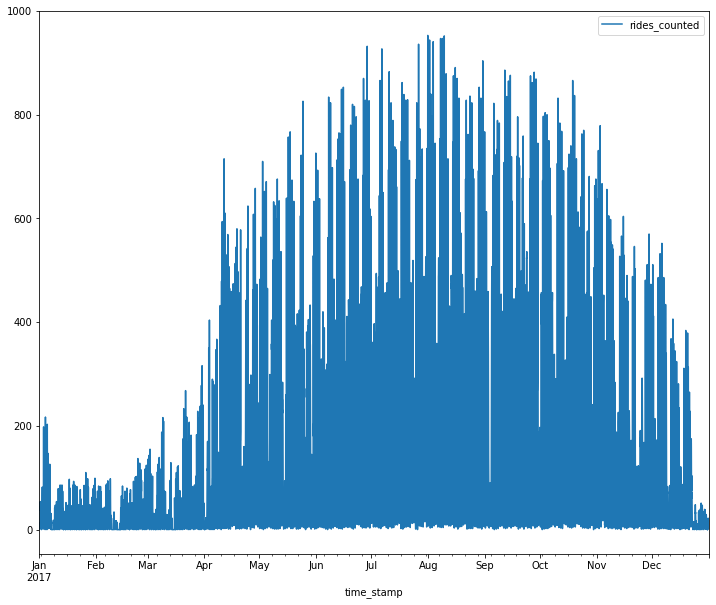

In [19]:
arimaData.plot(y="rides_counted")


In [20]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries):

    # Determing rolling statistics (168 window => weekly)
    rolmean = timeseries.rolling(window=168).mean()
    rolstd = timeseries.rolling(window=168).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
adfuller(arimaData['rides_counted'])


(-7.2273566936970814,
 2.0365894048235332e-10,
 44,
 17499,
 {'1%': -3.430723750472268,
  '5%': -2.8617051832726124,
  '10%': -2.5668579227683557},
 167199.01623403025)

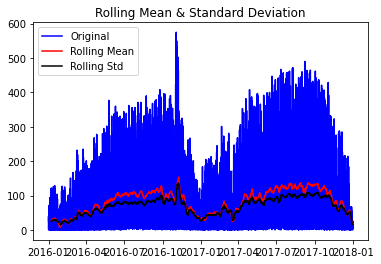

Results of Dickey-Fuller Test:

Test Statistic                -7.227357e+00
p-value                        2.036589e-10
#Lags Used                     4.400000e+01
Number of Observations Used    1.749900e+04
Critical Value (1%)           -3.430724e+00
Critical Value (5%)           -2.861705e+00
Critical Value (10%)          -2.566858e+00
dtype: float64


In [ ]:
test_stationarity(arimaData['rides_counted'])


p value is basically 0, no matter what size of rolling mean/std/number of years in data, so this data seems to be stationary. Overall (yearly) trend does seem to be 0.


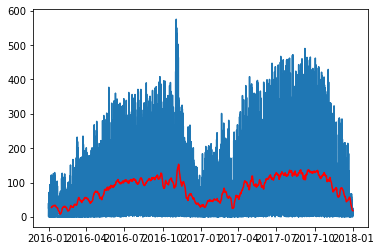

In [ ]:
moving_avg = arimaData.rolling(168).mean()
plt.plot(arimaData)
plt.plot(moving_avg, color='red')


### moving average


In [ ]:
moving_avg_diff = arimaData - moving_avg
moving_avg_diff.dropna(inplace=True)
moving_avg_diff


,number_of_trips
time_stamp,
2016-01-07 23:00:00,-16.470238
2016-01-08 00:00:00,-21.351190
2016-01-08 01:00:00,-23.136905
2016-01-08 02:00:00,-26.940476
2016-01-08 03:00:00,-26.904762
...,...
2017-12-31 19:00:00,-3.833333
2017-12-31 20:00:00,-13.797619
2017-12-31 21:00:00,-9.815476


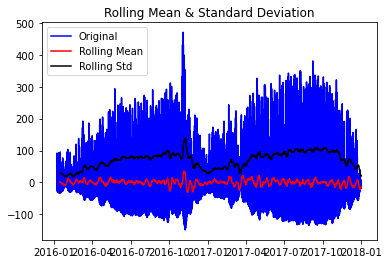

Results of Dickey-Fuller Test:

Test Statistic                -1.666078e+01
p-value                        1.574821e-29
#Lags Used                     4.200000e+01
Number of Observations Used    1.733400e+04
Critical Value (1%)           -3.430727e+00
Critical Value (5%)           -2.861707e+00
Critical Value (10%)          -2.566859e+00
dtype: float64


In [ ]:
test_stationarity(moving_avg_diff)


test statistic is now even lower, leading to a p-value of 0


### weighted moving average


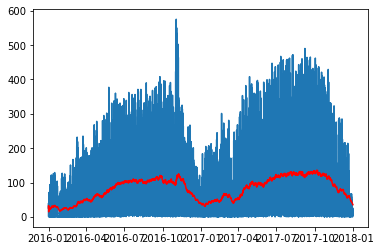

In [ ]:
# Provides exponential weighted functions
expwighted_avg = arimaData.ewm(halflife=168).mean()
plt.plot(arimaData)
plt.plot(expwighted_avg, color='red')


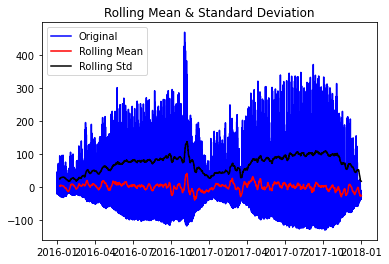

Results of Dickey-Fuller Test:

Test Statistic                -1.508228e+01
p-value                        8.421029e-28
#Lags Used                     4.400000e+01
Number of Observations Used    1.749900e+04
Critical Value (1%)           -3.430724e+00
Critical Value (5%)           -2.861705e+00
Critical Value (10%)          -2.566858e+00
dtype: float64


In [ ]:
ewma_diff = arimaData - expwighted_avg
test_stationarity(ewma_diff)


results are slightly worse than "normal" moving average, but p value is still 0


### differencing


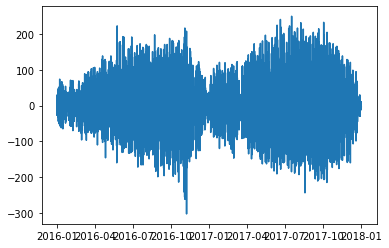

In [ ]:
diff = arimaData - arimaData.shift()
plt.plot(diff)


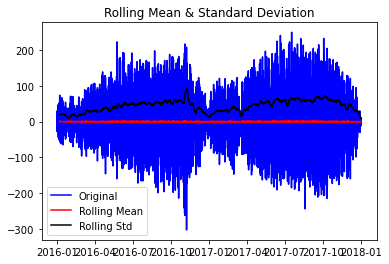

Results of Dickey-Fuller Test:

Test Statistic                   -29.860974
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    17498.000000
Critical Value (1%)               -3.430724
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


In [ ]:
diff.dropna(inplace=True)
test_stationarity(diff)


best result so far


### Decomposing


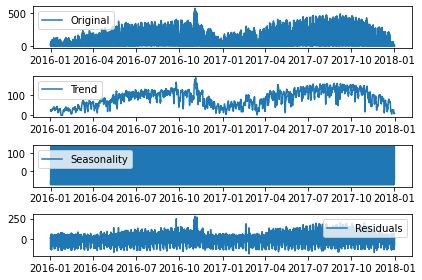

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition using moving averages
decomposition = seasonal_decompose(arimaData)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(arimaData, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


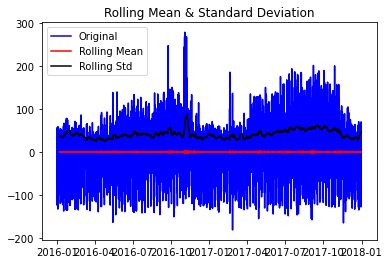

Results of Dickey-Fuller Test:

Test Statistic                   -36.054996
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    17475.000000
Critical Value (1%)               -3.430724
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


In [ ]:
decompose = residual
decompose.dropna(inplace=True)
test_stationarity(decompose)


decomposing leads to the overall best result regarding the Dickey-Fuller Test. Therefore, the decomposed values will be used for the ARIMA model


### ACF / PACF


In [ ]:
from statsmodels.tsa.stattools import acf, pacf


In [ ]:
lag_acf = acf(diff, nlags=5)
lag_pacf = pacf(diff, nlags=5, method='ols')


Text(0.5, 1.0, 'Autocorrelation Function')

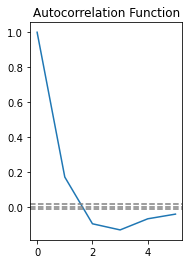

In [ ]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
# the axis lines are at around 0.01 so they are not that visible
plt.axhline(y=-1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')


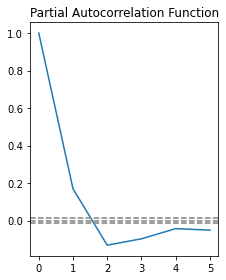

In [ ]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
# the axis lines are at around 0.01 so they are not that visible
plt.axhline(y=-1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


The lag value where acf crosse the upper confidence interval for the first time is around 1.7 so q=2

The lag value where pacf crosse the upper confidence interval for the first time is around 1.6 so p=2


## ARIMA model


In [ ]:
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
warnings.filterwarnings("ignore")
# p and q from above
model = ARIMA(decompose, order=(2, 1, 2))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                17520
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -84594.907
Date:                Mon, 24 Jan 2022   AIC                         169199.814
Time:                        18:12:49   BIC                         169238.670
Sample:                    01-01-2016   HQIC                        169212.609
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3006      0.004    -79.602      0.000      -0.308      -0.293
ar.L2          0.6994      0.004    185.121      0.000       0.692       0.707
ma.L1         -0.0003      0.006     -0.052      0.958      -0.013       0.012
ma.L2         -0.9997      0.006   -157.012      0.000      -1.012      -0.987
sigma2       915.0641   1.39e-05   6.61e+07      0.000     915.064     915.064
===================================================================================
Ljung-Box (L1) (Q):                 647.35   Jarque-Bera (JB):             10993.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.29e+22. Standard errors may be unstable.
"""

### ARIMA Forecasting


In [ ]:
decomposition = seasonal_decompose(testArimaData)
trend = decomposition.trend
seasonal = decomposition.seasonal


In [ ]:
validation_df = pd.DataFrame(trend)
# forecast 2018 data only
validation_df["residual_prediction"] = model_fit.forecast(
    steps=dt.datetime(2019, 1, 1, 0))
validation_df["seasonal"] = seasonal
# add back seasonal and trend to compare prediction to actual values
validation_df["prediction"] = validation_df["trend"] + \
    validation_df["seasonal"]+validation_df["residual_prediction"]
validation_df.dropna()


,trend,residual_prediction,seasonal,prediction
time_stamp,,,,
2018-01-01 12:00:00,8.541667,-0.240389,19.259868,27.561146
2018-01-01 13:00:00,8.416667,0.255252,20.674417,29.346336
2018-01-01 14:00:00,8.166667,-0.240733,24.169266,32.095200
2018-01-01 15:00:00,7.958333,0.255007,35.721636,43.934976
2018-01-01 16:00:00,7.916667,-0.240900,64.196739,71.872505
...,...,...,...,...
2018-12-31 07:00:00,23.979167,0.245138,16.210074,40.434378
2018-12-31 08:00:00,23.020833,-0.231425,77.045010,99.834418
2018-12-31 09:00:00,21.854167,0.245135,17.979305,40.078607


In [ ]:
testArimaData["prediction"] = validation_df["prediction"]
# set negative predictions to 0, since demand can't be negative
testArimaData["prediction"][testArimaData["prediction"] < 0] = 0
# round prediction to nearest integer, since bikes can't be half rented (does not affect error significantly)
testArimaData = testArimaData.round({"prediction": 0})
testArimaData["prediction_abs_error"] = abs(testArimaData["prediction"] -
                                            testArimaData["rides_counted"])
# the first and last 12 values are not predicted
testArimaData.dropna()


,number_of_trips,prediction,prediction_abs_error
time_stamp,,,
2018-01-01 12:00:00,8.0,28.0,20.0
2018-01-01 13:00:00,9.0,29.0,20.0
2018-01-01 14:00:00,21.0,32.0,11.0
2018-01-01 15:00:00,15.0,44.0,29.0
2018-01-01 16:00:00,18.0,72.0,54.0
...,...,...,...
2018-12-31 07:00:00,20.0,40.0,20.0
2018-12-31 08:00:00,61.0,100.0,39.0
2018-12-31 09:00:00,51.0,40.0,11.0


#### calculate prediction errors

Text(0.5, 1.0, 'absolute error in forecasting')

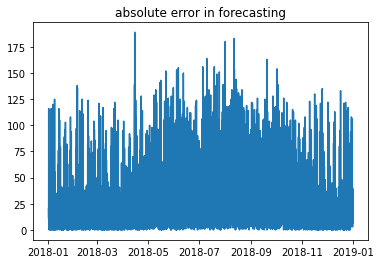

In [ ]:
plt.plot(testArimaData["prediction_abs_error"])
plt.title("absolute error in forecasting")


In [ ]:
print("mean squared error: " +
      str((testArimaData["prediction_abs_error"]**2).mean()))
print("mean absolute error: " +
      str(testArimaData["prediction_abs_error"].mean()))


mean squared error: 1305.0184294871794
mean absolute error: 25.421130952380953


In [ ]:
testArimaData["rides_counted"].mean()


76.32237442922374

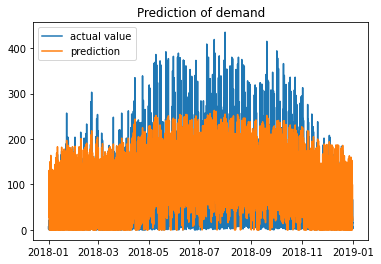

In [ ]:
plt.plot(testArimaData["rides_counted"], label="actual value")
plt.plot(testArimaData["prediction"], label="prediction")
plt.title("Prediction of demand")
plt.legend()


## Random Forest


Only include data data from 2018


In [ ]:
data_random_forest = data[data.index.year == 2018]


Remove target 'rides_counted' to retrieve the features


In [ ]:
target = data_random_forest['rides_counted']
features = data_random_forest.drop(['rides_counted'], axis=1)
feature_list = list(features.columns)
features.head(5)


,max_temp,min_temp,precip,dayofweek,month,hour,is_holiday_or_weekend
time_stamp,,,,,,,
2018-01-01 00:00:00,-10.6,-10.6,0.0,0,1,0,True
2018-01-01 01:00:00,-10.6,-10.6,0.0,0,1,1,True
2018-01-01 02:00:00,-11.1,-11.1,0.0,0,1,2,True
2018-01-01 03:00:00,-12.2,-12.2,0.0,0,1,3,True
2018-01-01 04:00:00,-11.7,-11.7,0.0,0,1,4,True


Split the data sets


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, target,  random_state=0)


In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (6570, 7)
Training Labels Shape: (6570,)
Testing Features Shape: (2190, 7)
Testing Labels Shape: (2190,)


Train Model


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
# Train the model on training data
rf.fit(train_features, train_labels)


RandomForestRegressor(n_estimators=1000, random_state=42)

In [ ]:
predictions = rf.predict(test_features)
predictions[predictions < 0]


array([], dtype=float64)

In [ ]:
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), ' rented bikes.')


Mean Absolute Error: 16.56  rented bikes.


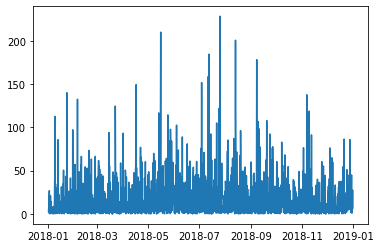

In [ ]:
errors = errors.sort_index()
plt.plot(errors)


## Polynomial regression


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


only include data from 2018


In [ ]:
data_polynomial_regression = data[data.index.year == 2018]


Function that transforms the input features to the wanted dimension


In [ ]:
def fit_and_transform_features_to_new_dimension(new_dim, features):
    poly_reg = PolynomialFeatures(degree=new_dim)
    return poly_reg.fit_transform(features)


PCA to reduce some noise before applying linear regression

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)
pca = PCA(n_components=1)
X_pca = pca.fit_transform(features_scaled)

In [ ]:
print(pca.explained_variance_ratio_[0])

0.30582824583324714


Using only one component does not supply a sufficient explained variance ratio of 95%.

Next we increase the number to five components

In [ ]:
pca5 = PCA(n_components=5)
X_pca5 = pca5.fit_transform(features_scaled)

In [ ]:
print(sum(pca5.explained_variance_ratio_))

0.9572898418368267


Using five components we reach an explained variance over 95%. Thus, we decide to use five components in the following regression.

new train-test split as we have the new variables with the pca 

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
    X_pca5, target,  random_state=0)

Function that creates a new regression model and fits it with input features


In [ ]:
def create_and_fit_model(test_features, test_labels):
    # normalization is redundant as features are already normalized for PCA, but to be on the safe side we normalize once more
    lin_reg_2 = LinearRegression(normalize=True)
    lin_reg_2.fit(test_features, test_labels)
    return lin_reg_2


Function to compute mean average error for a regression model


In [ ]:
def compute_mean_average_error(polynomial_regression, test_features, test_labels):
    predictions = polynomial_regression.predict(test_features)
    abs_error = abs(predictions - test_labels)
    return round(np.mean(abs_error), 2)


Compute mean average error for degree one to ten for test and training data set.


In [ ]:
# quick for range(1,8), 3min for range(1,11), compute time rises exponentially for higher ranges
test_errors = pd.Series([], dtype='float64')
training_errors = pd.Series([], dtype='float64')
for i in range(1, 11):
    train_features_dim_i = fit_and_transform_features_to_new_dimension(
        i, train_features)
    test_features_dim_i = fit_and_transform_features_to_new_dimension(
        i, test_features)
    regression_model_dim_i = create_and_fit_model(
        train_features_dim_i, train_labels)
    mean_avg_error_test = compute_mean_average_error(
        regression_model_dim_i, test_features_dim_i, test_labels)
    mean_avg_error_train = compute_mean_average_error(
        regression_model_dim_i, train_features_dim_i, train_labels)
    test_errors[i] = mean_avg_error_test
    training_errors[i] = mean_avg_error_train


Plot mean average error for the different degrees.


Text(0, 0.5, 'Mean squared error')

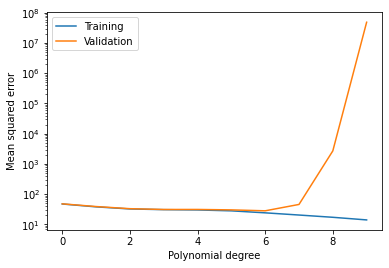

In [ ]:
plt.semilogy(range(len(training_errors)), training_errors,
             range(len(test_errors)), test_errors)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")


Show the five degrees with the lowest average error in the predction.


In [ ]:
test_errors.sort_values().head(n=5)


7    28.19
6    30.26
4    31.22
5    31.26
3    33.12
dtype: float64

We take the model with degree = 4.


## Regularization


Retrieve the five highest coefficients for our features


In [ ]:
train_features_dim_4 = fit_and_transform_features_to_new_dimension(
    4, train_features)
test_features_dim_4 = fit_and_transform_features_to_new_dimension(
    4, test_features)
regression_model_dim_4 = create_and_fit_model(
    train_features_dim_4, train_labels)
sorted_index_array = np.argsort(regression_model_dim_4.coef_)
regression_model_dim_4.coef_[sorted_index_array[-5:]]


array([ 9155.77916672, 15031.27780523, 15403.38426416, 32682.44078868,
       58285.65517623])

Retrieve the five lowest coeffecients for out features


In [ ]:
regression_model_dim_4.coef_[sorted_index_array[1:6]]


array([-52038.12606313, -24848.47531517, -19417.4568345 , -11818.18039256,
       -11128.98415731])

#### Ridge regression


Search for a good and appropriate alpha value.


In [ ]:
from sklearn.linear_model import Ridge
alphas = np.logspace(-10, 10, 100)
test_errors_l2 = pd.Series([], dtype='float64')
training_errors_l2 = pd.Series([], dtype='float64')
for alpha in alphas:
    model_L2 = Ridge(alpha=alpha, normalize=True, solver='lsqr')
    model_L2.fit(train_features_dim_4, train_labels)
    test_errors_l2[alpha] = compute_mean_average_error(
        model_L2, test_features_dim_4, test_labels)
    training_errors_l2[alpha] = compute_mean_average_error(
        model_L2, train_features_dim_4, train_labels)


Plot mean average error for the different alpha values


Text(0.5, 1.0, 'Ridge regression')

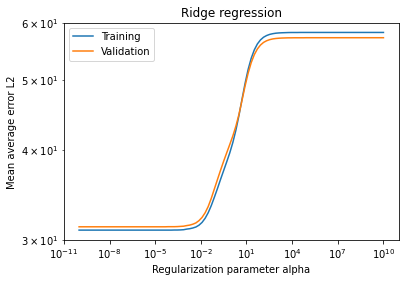

In [ ]:
plt.loglog(alphas, training_errors_l2, alphas, test_errors_l2)
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter alpha")
plt.ylabel("Mean average error L2")
plt.title("Ridge regression")

In [ ]:
print("We have the lowest mean average error of {0} for alpha = {1}".format(test_errors_l2[test_errors_l2.sort_values(
).head(n=1).index].values[0], str(test_errors_l2.sort_values().head(n=1).index)[14:19]))


We have the lowest mean average error of 31.28 for alpha = 1e-10


Thus with the regularization we could improve our mean average error slightly.


#### Lasso regression


In [ ]:
# takes 2 minutes
from sklearn.linear_model import Lasso
alphas = np.logspace(-10, 10, 100)
test_errors_l1 = pd.Series([], dtype='float64')
training_errors_l1 = pd.Series([], dtype='float64')
for alpha in alphas:
    model_L1 = Lasso(alpha=alpha)
    model_L1.fit(train_features_dim_4, train_labels)
    test_errors_l1[alpha] = compute_mean_average_error(
        model_L1, test_features_dim_4, test_labels)
    training_errors_l1[alpha] = compute_mean_average_error(
        model_L1, train_features_dim_4, train_labels)


Text(0.5, 1.0, 'Lasso regression')

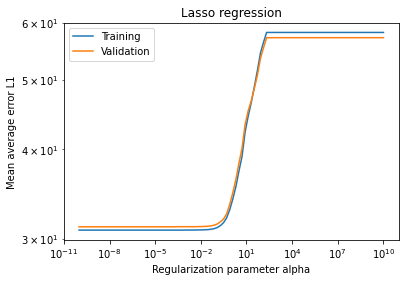

In [ ]:
plt.loglog(alphas, training_errors_l1, alphas, test_errors_l1)
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter alpha")
plt.ylabel("Mean average error L1")
plt.title("Lasso regression")


In [ ]:
print("We have the lowest mean average error of {0} for alpha = {1}".format(test_errors_l1[test_errors_l1.sort_values(
).head(n=1).index].values[0], str(test_errors_l1.sort_values().head(n=1).index)[14:19]))


We have the lowest mean average error of 31.19 for alpha = 1e-10
